## GLM approach using gamma models

In this notebook, we focused on moving away from OLS and into GLMs. 

To start this, we decided to refine our previous approaches, and perform a step-by-step data driven approach to chose which stressors are most impactful when it comes to yield. 

We also decided to not go trhough with the detrending we used before, and rather, use year as a cofactor. This is due to the fact that our previous detrending approach resulted in negative numbers, and a gamma model cannot handle these negative numbers. 

To start out with, we want to loop over all potential stressors, and see which ones are the most impactful on our yield. We do this to better understand how we want to build our end model. We extract AIC scores and rank the top 10 influencial stressor per crop. 

In [ ]:
# Libraries:

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

### Stressor looping and AIC

In [ ]:
# Suppress convergence warnings for this screening step, as some models may not fit perfectly
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

print("--- Starting Univariate Stressor Screening for Maize ---")

# --- 1. Load the Data ---
# We'll use the same pre-processed maize dataset from your EDA.
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    print(f"Successfully loaded dataset: {file_path}")

    # --- 2. Prepare Data for Modeling ---
    # As per our plan, we'll use raw yield as the dependent variable.
    # The Gamma GLM requires all dependent variable values to be > 0.
    if (df_maize['yield_maize'] <= 0).any():
        print("Warning: Found non-positive yield values. These will be excluded for the Gamma GLM.")
        df_maize = df_maize[df_maize['yield_maize'] > 0].copy()

    # Create the unique identifier for each grid cell for our fixed effects model.
    df_maize['cell_id'] = df_maize.groupby(['lat', 'lon']).ngroup()
    
    # --- 3. Identify Stressor Variables ---
    # Programmatically create a list of all potential climate stressor columns to test.
    # We exclude identifiers, the outcome variable, and control variables.
    excluded_cols = ['lat', 'lon', 'year', 'yield_maize', 'cell_id']
    stressor_variables = [col for col in df_maize.columns if col not in excluded_cols]
    
    print(f"\nFound {len(stressor_variables)} potential stressor variables to screen.")

    # --- 4. Screening Loop ---
    # This loop will fit a separate GLM for each stressor and store the results.
    results = []

    for stressor in stressor_variables:
        try:
            # Construct the formula for each model.
            # `year` and `C(cell_id)` are included as controls in every model.
            formula = f"yield_maize ~ year + {stressor} + C(cell_id)"
            
            # Fit the Gamma GLM. We use a log link, which is common and robust.
            # It ensures predictions are positive and makes coefficients easier to interpret.
            model = smf.glm(
                formula=formula, 
                data=df_maize, 
                family=sm.families.Gamma(link=sm.families.links.log()) #log linking might not be that important here !! 
            ).fit()
            
            # Extract AIC, coefficient, and p-value for the stressor
            aic = model.aic
            coef = model.params[stressor]
            p_value = model.pvalues[stressor]
            
            # Store the results
            results.append({
                'Stressor': stressor,
                'AIC': aic,
                'p_value': p_value,
                'Coefficient': coef
            })
            
        except Exception as e:
            print(f"Could not fit model for {stressor}. Error: {e}")

    # --- 5. Analyze and Display Results ---
    # Convert the results to a DataFrame and sort by AIC (lower is better).
    results_df = pd.DataFrame(results).sort_values(by='AIC', ascending=True).reset_index(drop=True)

    print("\n--- Top 10 Stressors for Maize (Ranked by AIC) ---")
    # Display the results, formatted for clarity
    print(results_df.head(10).to_string(formatters={
        'AIC': '{:,.2f}'.format,
        'p_value': '{:,.4f}'.format,
        'Coefficient': '{:,.4f}'.format
    }))

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Starting Univariate Stressor Screening for Maize ---
Successfully loaded dataset: ../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv

Found 30 potential stressor variables to screen.


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\env


--- Top 10 Stressors for Maize (Ranked by AIC) ---
                    Stressor      AIC p_value Coefficient
0            temperature_Jul 3,999.78  0.0000     -0.0355
1             soil_water_Jul 4,161.73  0.0000      0.8410
2  potential_evaporation_Jul 4,211.92  0.0000     -0.0009
3            temperature_May 4,214.72  0.0000      0.0179
4          precipitation_Jul 4,216.97  0.0000      0.0006
5                 soil_water 4,219.15  0.0000      1.0741
6                temperature 4,226.33  0.0000     -0.0321
7            temperature_Sep 4,238.02  0.0000     -0.0149
8        solar_radiation_Jul 4,244.10  0.0000     -0.0000
9             soil_water_Aug 4,253.50  0.0000      0.4382


## building a multivariate GLM using stressors identified above

To avoid multicolinearity, we wanna chose stressors that we dont think are hihgly correlated with each other. The top 5 stressors we already identified are: 

1. temperature_Jul (Heat)

2. soil_water_Jul (Water Availability)

3. potential_evaporation_Jul (Water Loss, driven by heat)

4. temperature_May (Early Season Heat)

5. precipitation_Jul (Water Input)

Physically, we know these are linked. A hot July (temperature_Jul ↑) causes more evaporation (potential_evaporation_Jul ↑), which in turn dries out the soil (soil_water_Jul ↓). They aren't independent pieces of information adn so we need to be careful when chosing which stressors to use.

So for the following models, we are going to start by just using our most inlfuencial stressor, before adding new info, that is not highly corrolated with the already in use stressors. 

In [2]:
# Suppress convergence warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

print("--- Step 2: Building Multivariate GLM for Maize ---")

# --- 1. Load and Prepare Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'
try:
    df_maize = pd.read_csv(file_path)
    df_maize = df_maize[df_maize['yield_maize'] > 0].copy()
    df_maize['cell_id'] = df_maize.groupby(['lat', 'lon']).ngroup()
    print("Data prepared successfully.")

    # --- 2. Fit a Sequence of Models ---
    
    # We'll store the AIC of each model to compare them at the end
    model_comparison = {}
    
    # --- Model 1: Our New Baseline (Top Predictor Only) ---
    print("\nFitting Model 1: Baseline with temperature_Jul...")
    formula1 = "yield_maize ~ year + temperature_Jul + C(cell_id)"
    model1 = smf.glm(formula=formula1, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 1 (Temp Jul)'] = model1.aic
    # print(model1.summary()) # Optional: uncomment to see full summary
    
    # --- Model 2: Adding the Next Best Predictor (Soil Water) ---
    # From our screening, soil_water_Jul was #2. Let's see if it adds explanatory power.
    print("Fitting Model 2: Adding soil_water_Jul...")
    formula2 = "yield_maize ~ year + temperature_Jul + soil_water_Jul + C(cell_id)"
    model2 = smf.glm(formula=formula2, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 2 (Temp Jul + Soil Jul)'] = model2.aic
    # print(model2.summary())

    # --- Model 3: Adding an Early-Season Predictor (May Temperature) ---
    # Temperature in May was ranked #4. Does an early-season effect matter on top of the July stress?
    print("Fitting Model 3: Adding temperature_May...")
    formula3 = "yield_maize ~ year + temperature_Jul + soil_water_Jul + temperature_May + C(cell_id)"
    model3 = smf.glm(formula=formula3, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 3 (Temp Jul + Soil Jul + Temp May)'] = model3.aic
    # print(model3.summary())

    # --- Model 4: Adding Non-Linearity with Splines ---
    # This is our key hypothesis: the effect of July temperature is non-linear.
    # We replace 'temperature_Jul' with a basis spline function 'bs()'.
    # df=4 means a cubic spline with one internal knot - a good, flexible start.
    print("Fitting Model 4: Adding Spline on temperature_Jul...")
    formula4 = "yield_maize ~ year + bs(temperature_Jul, df=4) + soil_water_Jul + C(cell_id)"
    model4 = smf.glm(formula=formula4, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 4 (Spline Temp Jul + Soil Jul)'] = model4.aic
    print(model4.summary()) # Let's look at the full summary for this one.

    # --- 3. Compare Model Performance ---
    print("\n--- Model Comparison (lower AIC is better) ---")
    aic_df = pd.DataFrame.from_dict(model_comparison, orient='index', columns=['AIC'])
    print(aic_df.sort_values(by='AIC').to_string(formatters={'AIC': '{:,.2f}'.format}))

except Exception as e:
    print(f"An error occurred: {e}")

--- Step 2: Building Multivariate GLM for Maize ---
Data prepared successfully.

Fitting Model 1: Baseline with temperature_Jul...
Fitting Model 2: Adding soil_water_Jul...
Fitting Model 3: Adding temperature_May...
Fitting Model 4: Adding Spline on temperature_Jul...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_maize   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1422
Model Family:                   Gamma   Df Model:                           47
Link Function:                    log   Scale:                       0.0088916
Method:                          IRLS   Log-Likelihood:                -1950.6
Date:                Tue, 28 Oct 2025   Deviance:                       13.002
Time:                        17:21:53   Pearson chi2:                     12.6
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9989
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

### interpretation:

First thing that sticks out to me is the Pseudo R-squared value. It is very high. The combo of year and individual cell_id fixed effects are explaining almost all the variance in the absolute yield values. This however makes sense, as a cell in a really ideal area should always have a higher average yield compared to a cell in a less fertile area. So our fixed effects are correctly capturing baseline dofferences, which means we can be more confident that the climate coeffeicants are truly explainig the deviations from the average in each cell. 

Looking at the coefficients, we need to remember that we used a log link, so they reprsent a multiplicative or precentage change. 

The intercept and c(cell_id) are our fixed effects. 
- The cell_id individual coeficcients are not really that intresting. These are simply herer to control for the baseline differences in location. 
- The year coeficcient: coef = 0.0107, P>|z| = 0.000 is our technology/management trend. It's positive and highly significant. It means that, holding all else constant, maize yields increased by about 1.07% per year on average across this period.

bs(temperature_Jul, df=4)[0] through [3]: These are the coefficients for our spline. Crucially, we do not interpret these numbers individually. They are the weights for the basis functions that, together, create the flexible curve for the effect of July temperature. The key takeaway here is that their p-values are all extremely low (0.000). This tells us that the curve they collectively define is a highly statistically significant predictor of yield.

soil_water_Jul: coef = 0.1651, P>|z| = 0.052. This is the effect of soil water in July. It's positive, as we'd expect (more water is generally good). The p-value of 0.052 is "marginally significant." It's right on the edge of the standard 0.05 cutoff. In Model 2, it was highly significant, but its importance has been slightly reduced by the addition of the temperature spline, suggesting some overlap in the information they provide.


#### Comparing the 4 models !!

All of the new models are an improvement from the original single stressor models, which was expected. 

1. Model 1 -> Model 2: Adding soil_water_Jul lowers the AIC (from 3999.78 to 3998.33). The improvement is small but real. It tells us that knowing the soil moisture adds a little bit of explanatory power on top of knowing the temperature.

2. Model 2 -> Model 4: Allowing temperature_Jul to be a flexible curve (spline) instead of a straight line lowers the AIC again (from 3998.33 to 3997.27). This confirms your non-linear hypothesis! The curve is a better fit.

3. The Big Finding (Model 2 -> Model 3): Your observation is spot on. Adding temperature_May to the model with linear July temperature and soil water causes a huge drop in AIC (from 3998.33 down to 3947.66). This is a much larger improvement than we got from adding the spline. It's a very strong signal that conditions at the start of the growing season have a major impact on the final yield, even after accounting for the critical stress period in July.

This suggests that a warmer May can lead to a better early season growth and root development for Maize, making it more resiliant to the heat and water stress it can face in July. And then the oposite is also true, a bad start in Mayb can make the plant more vulnerable to any stress that comes later. 

However, these findings just further prove our original interraction hypothesis. 

#### Using model 3, lets test for interractions and make a new model

In [ ]:
# Cell: Final Multivariate Model with Interaction for Maize
print("\n--- Step 2b: Fitting Best Model with Spline and Interaction ---")

try:
    # --- Model 5: Spline on July Temp *INTERACTING WITH* May Temp ---
    # The '*' in the formula tells statsmodels to include the main effects of both
    # variables AND their interaction term. This is a powerful and concise way
    # to test our new hypothesis.
    formula5 = "yield_maize ~ year + bs(temperature_Jul, df=4) * temperature_May + C(cell_id)"
    formula5 = "yield_maize ~ year + temperature_Jul * temperature_May + bs(lat, df=4) + bs(lon, df=4)" #try lat/lon interraction? 
    
    model5 = smf.glm(formula=formula5, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()

    print("\n--- Final Model (Model 5) Summary ---")
    print(model5.summary())

    print(f"\nComparing AICs:")
    print(f"  Previous Best AIC (Model 3): {model_comparison['Model 3 (Temp Jul + Soil Jul + Temp May)']:,.2f}")
    print(f"  New Model AIC (Model 5):     {model5.aic:,.2f}")

except Exception as e:
    print(f"An error occurred: {e}")


--- Step 2b: Fitting Best Model with Spline and Interaction ---

--- Final Model (Model 5) Summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_maize   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1418
Model Family:                   Gamma   Df Model:                           51
Link Function:                    log   Scale:                       0.0082860
Method:                          IRLS   Log-Likelihood:                -1891.0
Date:                Tue, 28 Oct 2025   Deviance:                       11.989
Time:                        20:57:15   Pearson chi2:                     11.7
No. Iterations:                     9   Pseudo R-squ. (CS):             0.9994
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


#### model 5 analysis

We see a decrease in our AIC score when adding the interraction term !! nice. We also see that each individual part of our model is significant, but is it a significant improvment to the fit when we add the inteaction term? To test this we need to perform a likelihopod ratio test. This simply tests our current "full-model" to a "reduced model", where we dont have the interraction. 

In [4]:
# Cell: Likelihood Ratio Test for the Interaction Term

print("\n--- Testing Significance of the Full Interaction Term ---")

try:
    # First, we need to create the "reduced" model. This model includes both
    # temperature variables as main effects, but NOT their interaction.
    formula_reduced = "yield_maize ~ year + bs(temperature_Jul, df=4) + temperature_May + C(cell_id)"
    
    model_reduced = smf.glm(
        formula=formula_reduced, 
        data=df_maize, 
        family=sm.families.Gamma(link=sm.families.links.log())
    ).fit()
    
    # The Likelihood Ratio Test
    lr_statistic = 2 * (model5.llf - model_reduced.llf)
    degrees_of_freedom = model5.df_model - model_reduced.df_model
    
    # We use a chi-squared distribution to get the p-value
    from scipy.stats import chi2
    p_value_interaction = chi2.sf(lr_statistic, degrees_of_freedom)

    print(f"Likelihood Ratio Test Statistic: {lr_statistic:.4f}")
    print(f"Degrees of Freedom: {degrees_of_freedom}")
    print(f"P-value for the interaction term as a group: {p_value_interaction:.4f}")
    
    if p_value_interaction < 0.05:
        print("\nConclusion: The interaction is statistically significant. The effect of July temperature on yield DEPENDS on the May temperature.")
    else:
        print("\nConclusion: The interaction is not statistically significant.")

except Exception as e:
    print(f"An error occurred during the Likelihood Ratio Test: {e}")


--- Testing Significance of the Full Interaction Term ---
Likelihood Ratio Test Statistic: 69.5365
Degrees of Freedom: 4
P-value for the interaction term as a group: 0.0000

Conclusion: The interaction is statistically significant. The effect of July temperature on yield DEPENDS on the May temperature.


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


#### more analysis on model 5 and visualizations

The individual coefficients for the interaction terms are difficult to interpret directly. The best way to understand an interaction is to visualize it.
What does the interaction we added mean? It means the vulnerability curve for July temperature is not fixed. It changes its shape depending on the temperature in May.

Let's plot this. We will generate the vulnerability curve for July temperature for three different scenarios:
- A cool May (e.g., the 10th percentile of May temperatures)
- An average May (the 50th percentile, or median)
- A warm May (the 90th percentile)

If our hypothesis is correct, we should see three different curves!


--- Visualizing the Interaction with Confidence Intervals ---


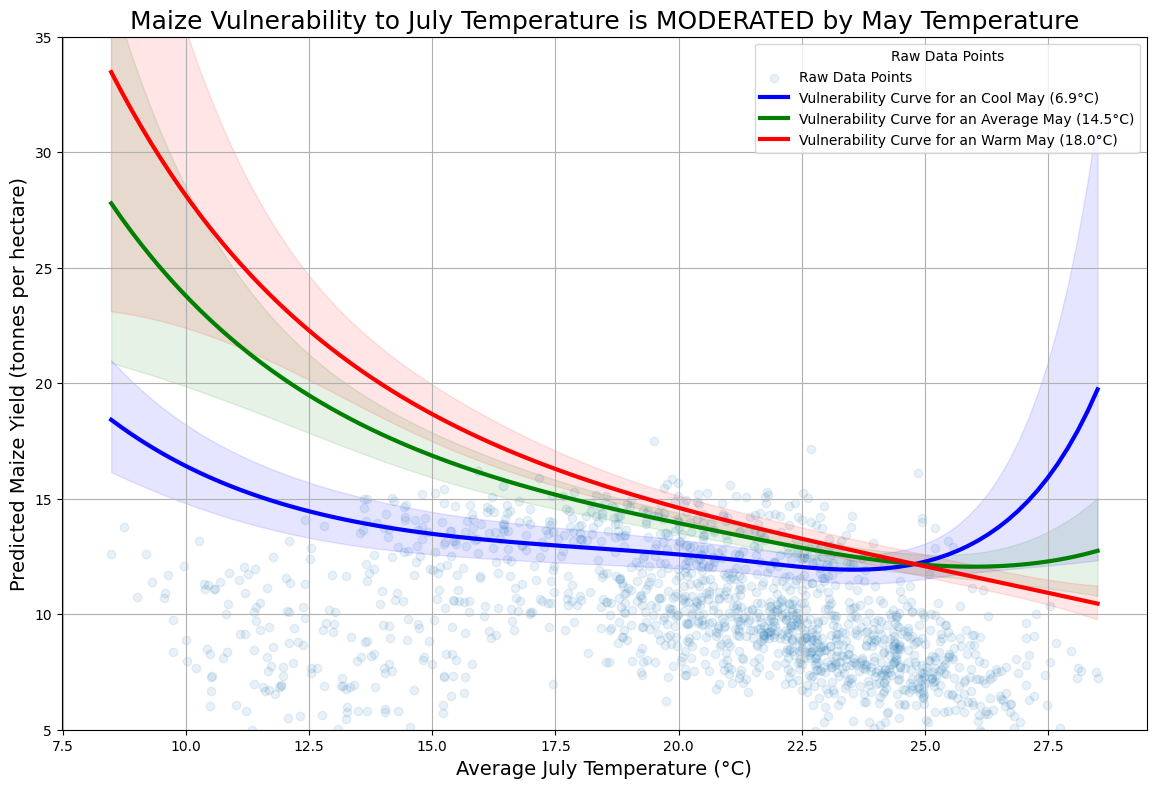

In [6]:
# Cell: Visualize the Interaction Effect with Confidence Intervals
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("\n--- Visualizing the Interaction with Confidence Intervals ---")

# --- 1. Get the levels for May temperature ---
cool_may = df_maize['temperature_May'].quantile(0.10)
avg_may = df_maize['temperature_May'].quantile(0.50)
warm_may = df_maize['temperature_May'].quantile(0.90)

# --- 2. Create a prediction grid ---
x_range_jul = np.linspace(df_maize['temperature_Jul'].min(), df_maize['temperature_Jul'].max(), 100)
scenarios = {
    f'Cool May ({cool_may:.1f}°C)': cool_may,
    f'Average May ({avg_may:.1f}°C)': avg_may,
    f'Warm May ({warm_may:.1f}°C)': warm_may
}
colors = {'Cool': 'blue', 'Average': 'green', 'Warm': 'red'}

# --- 3. Plot the base scatter plot ---
plt.figure(figsize=(14, 9))
plt.scatter(df_maize['temperature_Jul'], df_maize['yield_maize'], alpha=0.1, label='Raw Data Points')

# --- 4. Loop through scenarios to predict and plot ---
for label, may_temp in scenarios.items():
    # Create a dataframe with all necessary variables for prediction
    pred_df = pd.DataFrame({
        'temperature_Jul': x_range_jul,
        'temperature_May': may_temp,
        'year': df_maize['year'].mean(),
        'cell_id': 0  # Predict for the reference cell
    })
    
    # Get predictions and confidence intervals
    preds = model5.get_prediction(pred_df)
    pred_summary = preds.summary_frame(alpha=0.05) # alpha=0.05 for 95% CI
    
    # Extract key parts from the summary
    y_preds = pred_summary['mean']
    ci_lower = pred_summary['mean_ci_lower']
    ci_upper = pred_summary['mean_ci_upper']
    
    # Plot the regression line and the confidence interval
    color_key = label.split(' ')[0]
    plt.plot(x_range_jul, y_preds, color=colors[color_key], linewidth=3, label=f'Vulnerability Curve for an {label}')
    plt.fill_between(x_range_jul, ci_lower, ci_upper, color=colors[color_key], alpha=0.1)

# --- 5. Formatting ---
plt.title('Maize Vulnerability to July Temperature is MODERATED by May Temperature', fontsize=18)
plt.xlabel('Average July Temperature (°C)', fontsize=14)
plt.ylabel('Predicted Maize Yield (tonnes per hectare)', fontsize=14)
plt.grid(True)
plt.legend(title="Raw Data Points", loc="upper right")
# Adjust y-axis to a more realistic range to avoid showing extreme extrapolations
plt.ylim(bottom=5, top=35) 
plt.show()

#### visalization analysis

- The X-axis is our primary stressor: temperature_Jul.
- The Y-axis is the outcome we care about: Predicted Yield.
- The three separate lines show how the relationship between the X and Y axes changes depending on our third variable, temperature_May.

1. A warm start is a good start: The red curve (Warm May) starts at a much higher predicted yield than the blue curve (Cool May). This suggests that warmer May temperatures allow the maize to establish itself better and achieve a higher yield potential.

2. The Interaction Effect (The "So What?"): The vulnerability to July heat is not static.
    - After a warm May (red line), the yield potential is high, but the crop is also more sensitive to increasing July heat, showing a steep and continuous decline as temperatures rise.
    - After a cool May (blue line), the yield potential is lower, but the crop appears somewhat more resilient to moderate increases in July temperature (the curve is flatter in the 15-23°C range).

3. The "Cliff Edge": The model is uncertain what happens to cool-spring crops when they are hit with extreme (>25°C) July heat because it rarely happens in the historical data. However, for average and warm springs, the evidence clearly shows that high July temperatures lead to a strong, non-linear decline in yield.

### What we can say so far

1. We've Quantified the Long-Term Trend: "After controlling for location-specific advantages, we found that maize yields in Northern Italy have been increasing by approximately 1.1% per year from 1982-2016. This is likely due to a combination of technological and management improvements." (This comes from the year coefficient).

2. We've Confirmed a Critical Vulnerability Period: "Our analysis confirms that the single month of July is a critical period for maize yield. Climate stressors during this month have a disproportionately large impact compared to the growing season as a whole."

3. We've Modeled a Non-Linear "Damage Curve": "The relationship between July heat and maize yield is not a straight line. Our model shows that the damage accelerates at higher temperatures. The difference between a 24°C and 25°C July is significantly more harmful than the difference between an 18°C and 19°C July." (This is the contribution of the spline).

4. The Main Finding - We've Discovered a Resilience Factor: "Most importantly, we discovered that the vulnerability of maize to July heat is not fixed. It is significantly moderated by conditions earlier in the season. A warmer May leads to higher overall yield potential, making the crop more robust and resilient against subsequent heat stress in July." (This is the story told by your interaction plot).

#### EXPLORING PRECIPITATION IN JULY IN RELATION TO OUR CURRENT BEST MODEL

In [7]:
# Suppress convergence warnings that might arise during model fitting
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

print("--- Step A: Finalizing the Best Maize Model ---")

# --- 1. Load and Prepare Data ---
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'

try:
    df_maize = pd.read_csv(file_path)
    # Ensure yield is positive for the Gamma model
    df_maize = df_maize[df_maize['yield_maize'] > 0].copy()
    # Create the cell_id for fixed effects
    df_maize['cell_id'] = df_maize.groupby(['lat', 'lon']).ngroup()
    print("Data prepared successfully.")

    # --- 2. Fit the Sequence of Competing Models ---
    
    # Dictionary to store the AIC of each model for comparison
    model_comparison = {}
    # Dictionary to store the fitted model objects
    models = {}

    # --- Model 5: Our Current Best (from the previous step) ---
    print("\nFitting Model 5: Spline(Temp Jul) * Temp May (Our Current Best)...")
    formula5 = "yield_maize ~ year + bs(temperature_Jul, df=4) * temperature_May + C(cell_id)"
    model5 = smf.glm(formula=formula5, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 5 (TempJul*TempMay)'] = model5.aic
    models['Model 5 (TempJul*TempMay)'] = model5
    
    # --- Model 6: Adding Precipitation as a Main Effect ---
    # Here, we test if adding rainfall in July improves the model.
    print("Fitting Model 6: Adding Precipitation_Jul...")
    formula6 = "yield_maize ~ year + bs(temperature_Jul, df=4) * temperature_May + precipitation_Jul + C(cell_id)"
    model6 = smf.glm(formula=formula6, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 6 (Add PrecipJul)'] = model6.aic
    models['Model 6 (Add PrecipJul)'] = model6

    # --- Model 7: Testing the Heat x Drought Interaction ---
    # This model tests if the effect of July temperature is made worse by a lack of rain in the same month.
    # The formula `A * B + A * C` ensures we keep the first interaction while adding the second.
    print("Fitting Model 7: Testing Temp_Jul * Precipitation_Jul Interaction...")
    formula7 = "yield_maize ~ year + bs(temperature_Jul, df=4) * temperature_May + bs(temperature_Jul, df=4) * precipitation_Jul + C(cell_id)"
    model7 = smf.glm(formula=formula7, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    model_comparison['Model 7 (Add TempJul*PrecipJul Interaction)'] = model7.aic
    models['Model 7 (Add TempJul*PrecipJul Interaction)'] = model7
    
    # --- 3. Compare Model Performance ---
    print("\n--- Final Model Comparison (lower AIC is better) ---")
    aic_df = pd.DataFrame.from_dict(model_comparison, orient='index', columns=['AIC'])
    # Sort the results to easily see the best model
    aic_df = aic_df.sort_values(by='AIC')
    print(aic_df.to_string(formatters={'AIC': '{:,.2f}'.format}))

    # --- 4. Display Summary of the Winning Model ---
    # Programmatically find the name of the model with the lowest AIC
    best_model_name = aic_df.index[0]
    print(f"\n--- Summary for the Best Model: {best_model_name} ---")
    best_model = models[best_model_name]
    print(best_model.summary())

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step A: Finalizing the Best Maize Model ---
Data prepared successfully.

Fitting Model 5: Spline(Temp Jul) * Temp May (Our Current Best)...
Fitting Model 6: Adding Precipitation_Jul...
Fitting Model 7: Testing Temp_Jul * Precipitation_Jul Interaction...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(



--- Final Model Comparison (lower AIC is better) ---
                                                 AIC
Model 7 (Add TempJul*PrecipJul Interaction) 3,878.16
Model 5 (TempJul*TempMay)                   3,885.98
Model 6 (Add PrecipJul)                     3,887.54

--- Summary for the Best Model: Model 7 (Add TempJul*PrecipJul Interaction) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_maize   No. Observations:                 1470
Model:                            GLM   Df Residuals:                     1413
Model Family:                   Gamma   Df Model:                           56
Link Function:                    log   Scale:                       0.0082173
Method:                          IRLS   Log-Likelihood:                -1882.1
Date:                Tue, 28 Oct 2025   Deviance:                       11.844
Time:                        22:05:07   Pearson chi2:                     11.6
No. Iterations:      

#### testing if adding the bs(temperature_Jul, df=4) * precipitation_Jul interaction term provides a significant improvement over Model 5.

- Null Hypothesis (H₀): The interaction term adds no significant explanatory power. The simpler model (Model 5) is sufficient.
- Alternative Hypothesis (H₁): The interaction term is significant. The more complex model (Model 7) is a statistically better fit.

In [8]:
# Cell: Likelihood Ratio Test for the Heat x Drought Interaction

print("\n--- Testing Significance of the TempJul*PrecipJul Interaction Term ---")

try:
    # Model 7 is our "full" model. Model 5 is our "reduced" model.
    lr_statistic = 2 * (model7.llf - model5.llf)
    degrees_of_freedom = model7.df_model - model5.df_model
    
    # We use a chi-squared distribution to get the p-value
    from scipy.stats import chi2
    p_value_interaction = chi2.sf(lr_statistic, degrees_of_freedom)

    print(f"Likelihood Ratio Test Statistic: {lr_statistic:.4f}")
    print(f"Degrees of Freedom difference: {degrees_of_freedom}")
    print(f"P-value for the interaction as a group: {p_value_interaction:.4f}")
    
    if p_value_interaction < 0.05:
        print("\nConclusion: The improvement from adding the heat x precipitation interaction is statistically significant.")
    else:
        print("\nConclusion: The interaction is not statistically significant; the simpler Model 5 is preferred.")

except Exception as e:
    print(f"An error occurred during the Likelihood Ratio Test: {e}")


--- Testing Significance of the TempJul*PrecipJul Interaction Term ---
Likelihood Ratio Test Statistic: 17.8150
Degrees of Freedom difference: 5
P-value for the interaction as a group: 0.0032

Conclusion: The improvement from adding the heat x precipitation interaction is statistically significant.


#### interpretation of model 7

AIC Comparison: Model 7's AIC (3,878.16) is the best yet. This is our first clue that we've found a very good combination of predictors.

Pseudo R-squ.: 0.9994: Still extremely high, which is great. It confirms that the fixed effects (cell_id) and the overall trend (year) are successfully capturing the vast majority of the baseline yield variation.

1. Main Effect of Precipitation (precipitation_Jul)
    - coef = -0.0009, P>|z| = 0.167
    - Interpretation: On its own, the main effect of July precipitation is not statistically significant and is very close to zero. This seems counter-intuitive at first. Doesn't more rain lead to more yield? What this tells us is that, on average, the effect of rain is not consistent. Sometimes it helps, sometimes it doesn't. This is because its importance depends on another factor. 

2. The Interaction Effect (bs(temperature_Jul...):precipitation_Jul)
    - This is the most important new finding. Let's look at the coefficients:
        - bs(...)[0]:precipitation_Jul: p=0.067 (marginally significant)
        - bs(...)[3]:precipitation_Jul: p=0.005 (highly significant!)
    - Interpretation: The fact that these interaction terms are significant (especially the one for the highest temperature part of the spline) tells us that the effect of July precipitation DEPENDS on the July temperature.
    - What is the direction? The coefficient for the significant interaction ([3]) is positive (+0.0056). Remember that the main effect of very high July temperature is strongly negative (as seen by the large negative spline coefficients in our previous models). This positive interaction coefficient means that as precipitation_Jul increases, it makes the negative effect of temperature less negative.

While July precipitation on its own is not a universally strong predictor of maize yield, our model reveals a significant heat-drought interaction. The data shows that adequate rainfall in July acts as a crucial buffer against the damaging effects of extreme heat. The negative impact of a very hot July is significantly less severe in years that also have higher precipitation.

#### visualizing a wet vs dry july in relation to the interractions 


--- Visualizing the Heat x Drought (TempJul * PrecipJul) Interaction ---
Plotting for a Dry July (27.8 mm), Average July (74.7 mm), and Wet July (181.7 mm)


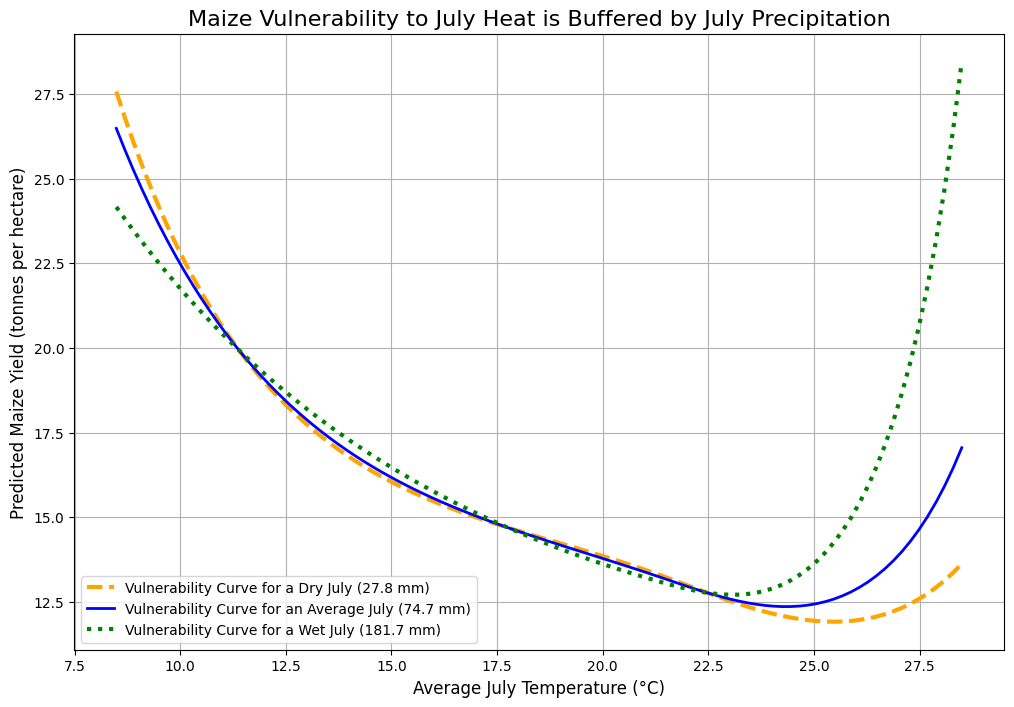

In [9]:
# Cell: Visualize the Heat x Drought Interaction Effect
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Visualizing the Heat x Drought (TempJul * PrecipJul) Interaction ---")

# --- 1. Get the levels for July precipitation ---
dry_jul = df_maize['precipitation_Jul'].quantile(0.10)
avg_jul = df_maize['precipitation_Jul'].quantile(0.50)
wet_jul = df_maize['precipitation_Jul'].quantile(0.90)

print(f"Plotting for a Dry July ({dry_jul:.1f} mm), Average July ({avg_jul:.1f} mm), and Wet July ({wet_jul:.1f} mm)")

# --- 2. Create a prediction grid ---
x_range_jul_temp = np.linspace(df_maize['temperature_Jul'].min(), df_maize['temperature_Jul'].max(), 100)

# Create a base dataframe for predictions
pred_df_base = pd.DataFrame({
    'temperature_Jul': x_range_jul_temp,
    'temperature_May': df_maize['temperature_May'].mean(), # Hold May temp constant
    'year': df_maize['year'].mean(),
    'cell_id': 0
})

# Create dataframes for each precipitation scenario
pred_df_dry = pred_df_base.copy()
pred_df_dry['precipitation_Jul'] = dry_jul

pred_df_avg = pred_df_base.copy()
pred_df_avg['precipitation_Jul'] = avg_jul

pred_df_wet = pred_df_base.copy()
pred_df_wet['precipitation_Jul'] = wet_jul


# --- 3. Generate Predictions using our best model (Model 7) ---
y_preds_dry = model7.predict(pred_df_dry)
y_preds_avg = model7.predict(pred_df_avg)
y_preds_wet = model7.predict(pred_df_wet)

# --- 4. Plot the Results ---
plt.figure(figsize=(12, 8))

# Plot the vulnerability curves
plt.plot(x_range_jul_temp, y_preds_dry, color='orange', linewidth=3, linestyle='--', label=f'Vulnerability Curve for a Dry July ({dry_jul:.1f} mm)')
plt.plot(x_range_jul_temp, y_preds_avg, color='blue', linewidth=2, label=f'Vulnerability Curve for an Average July ({avg_jul:.1f} mm)')
plt.plot(x_range_jul_temp, y_preds_wet, color='green', linewidth=3, linestyle=':', label=f'Vulnerability Curve for a Wet July ({wet_jul:.1f} mm)')

# --- Formatting ---
plt.title('Maize Vulnerability to July Heat is Buffered by July Precipitation', fontsize=16)
plt.xlabel('Average July Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Maize Yield (tonnes per hectare)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

--- Advanced Visualization for the Champion Maize Model ---
Champion model (Model 7) has been fitted.

Generating single plot with transparent confidence intervals...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


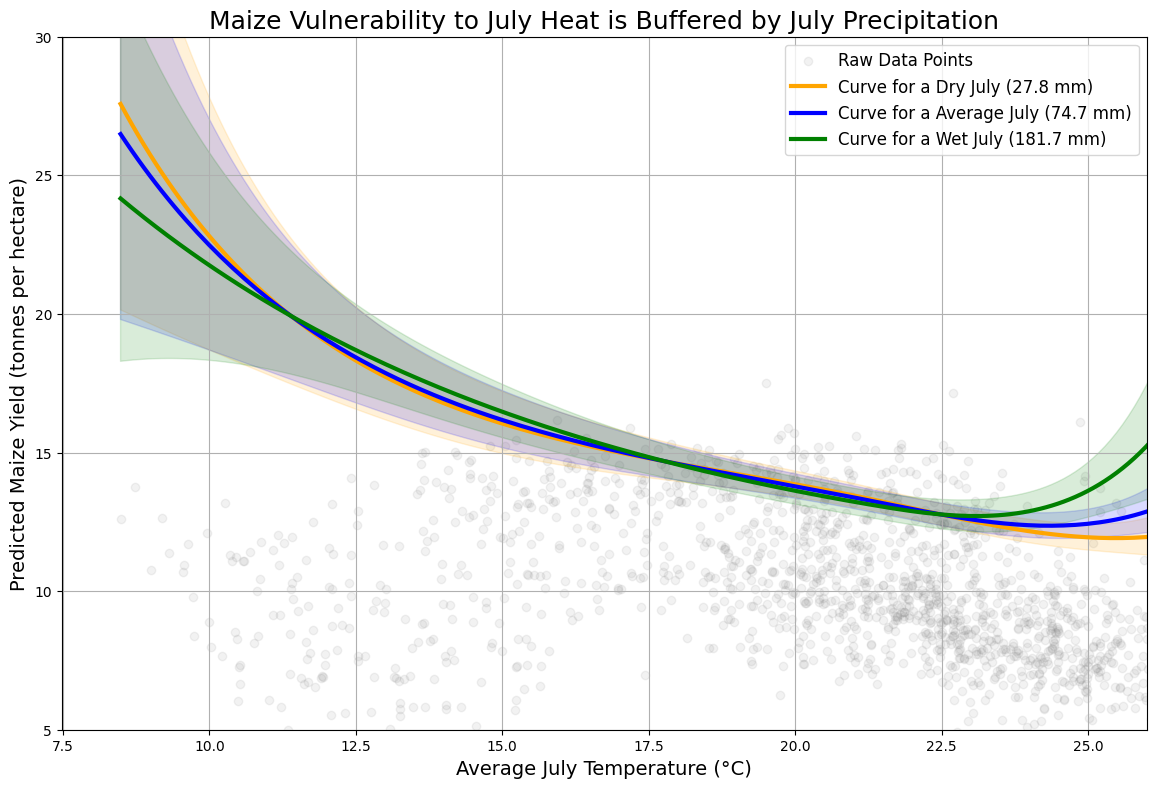


--- Generating REFINED faceted plot with adjusted axes ---


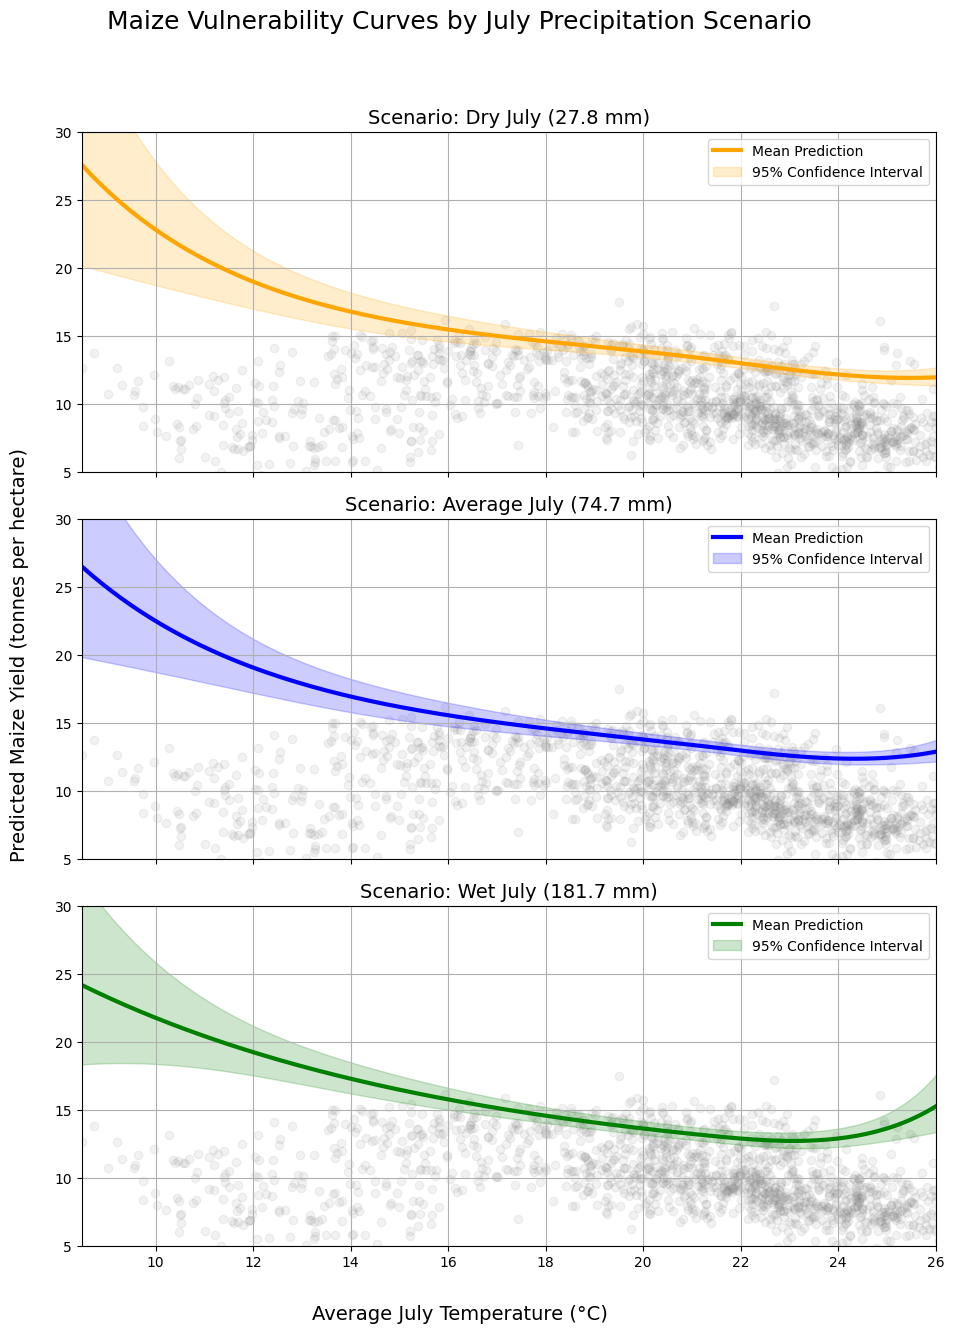

In [12]:
# Cell: Advanced Visualization of the Final Maize Model
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

print("--- Advanced Visualization for the Champion Maize Model ---")

# --- 1. Load Data and Fit the Best Model (Model 7) ---
# This ensures this cell can be run independently
file_path = '../data-cherry-pick/maize_ITnorth_core42_1982_2016_allstressors_with_monthly.csv'
df_maize = pd.read_csv(file_path)
df_maize = df_maize[df_maize['yield_maize'] > 0].copy()
df_maize['cell_id'] = df_maize.groupby(['lat', 'lon']).ngroup()

formula7 = "yield_maize ~ year + bs(temperature_Jul, df=4) * temperature_May + bs(temperature_Jul, df=4) * precipitation_Jul + C(cell_id)"
model7 = smf.glm(formula=formula7, data=df_maize, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print("Champion model (Model 7) has been fitted.")


# --- 2. Define Scenarios and Prediction Grid ---
dry_jul = df_maize['precipitation_Jul'].quantile(0.10)
avg_jul = df_maize['precipitation_Jul'].quantile(0.50)
wet_jul = df_maize['precipitation_Jul'].quantile(0.90)

scenarios = {
    f'Dry July ({dry_jul:.1f} mm)': dry_jul,
    f'Average July ({avg_jul:.1f} mm)': avg_jul,
    f'Wet July ({wet_jul:.1f} mm)': wet_jul
}
colors = {'Dry': 'orange', 'Average': 'blue', 'Wet': 'green'}

# Define the temperature range for plotting
x_range_jul_temp = np.linspace(df_maize['temperature_Jul'].min(), df_maize['temperature_Jul'].max(), 200)

# Create a base dataframe for predictions
pred_df_base = pd.DataFrame({
    'temperature_Jul': x_range_jul_temp,
    'temperature_May': df_maize['temperature_May'].mean(),
    'year': df_maize['year'].mean(),
    'cell_id': 0
})

# --- VISUALIZATION 1: SINGLE PLOT WITH CONFIDENCE INTERVALS ---
print("\nGenerating single plot with transparent confidence intervals...")

plt.figure(figsize=(14, 9))
plt.scatter(df_maize['temperature_Jul'], df_maize['yield_maize'], alpha=0.1, label='Raw Data Points', color='gray')

for label, precip_val in scenarios.items():
    pred_df = pred_df_base.copy()
    pred_df['precipitation_Jul'] = precip_val
    
    preds = model7.get_prediction(pred_df)
    pred_summary = preds.summary_frame(alpha=0.05)
    
    color_key = label.split(' ')[0]
    plt.plot(x_range_jul_temp, pred_summary['mean'], color=colors[color_key], linewidth=3, label=f'Curve for a {label}')
    plt.fill_between(x_range_jul_temp, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color=colors[color_key], alpha=0.15)

plt.title('Maize Vulnerability to July Heat is Buffered by July Precipitation', fontsize=18)
plt.xlabel('Average July Temperature (°C)', fontsize=14)
plt.ylabel('Predicted Maize Yield (tonnes per hectare)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.ylim(bottom=5, top=30) # Set a realistic Y-axis
plt.xlim(right=26)        # IMPORTANT: Limit X-axis to avoid showing extrapolation
plt.show()



# Cell: REFINED Facet Plot with Adjusted Y-Axis

print("\n--- Generating REFINED faceted plot with adjusted axes ---")

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True) # Removed sharey=True to set manually
fig.suptitle('Maize Vulnerability Curves by July Precipitation Scenario', fontsize=18, y=0.93)

for i, (label, precip_val) in enumerate(scenarios.items()):
    ax = axes[i]
    color_key = label.split(' ')[0]

    # Plot raw data on each subplot for context
    ax.scatter(df_maize['temperature_Jul'], df_maize['yield_maize'], alpha=0.1, color='gray')

    # Create predictions for this specific scenario
    pred_df = pred_df_base.copy()
    pred_df['precipitation_Jul'] = precip_val
    preds = model7.get_prediction(pred_df)
    pred_summary = preds.summary_frame(alpha=0.05)
    
    # Plot the line and confidence interval
    ax.plot(x_range_jul_temp, pred_summary['mean'], color=colors[color_key], linewidth=3, label='Mean Prediction')
    ax.fill_between(x_range_jul_temp, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color=colors[color_key], alpha=0.2, label='95% Confidence Interval')
    
    ax.set_title(f'Scenario: {label}', fontsize=14)
    ax.grid(True)
    ax.legend()
    
    # --- KEY IMPROVEMENT ---
    # Set the axis limits to a more meaningful range
    ax.set_xlim(df_maize['temperature_Jul'].min(), 26) # Focus on the data-rich region
    ax.set_ylim(5, 30)                               # Adjust the Y-axis as you suggested!

# Common labels
fig.text(0.5, 0.06, 'Average July Temperature (°C)', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Predicted Maize Yield (tonnes per hectare)', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.08, 0.08, 1, 0.9])
plt.show()

The final model reveals a complex, non-linear relationship between July temperature and maize yield. Yields are highest at cooler July temperatures and decrease as heat stress intensifies, reaching a point of maximum stress (lowest predicted yield) around 23-25°C. The model's key finding is a statistically significant interaction with precipitation: while the yield difference between wet and dry years is minimal at cooler temperatures, a clear separation emerges under high heat stress. For example, at a stressful 24°C, a wet July (182 mm) is predicted to yield approximately 1 tonne per hectare more than a dry July (28 mm), demonstrating that adequate rainfall is a key resilience factor that mitigates the most damaging effects of extreme heat. The widening confidence intervals at the temperature extremes responsibly highlight that the model's predictions are most certain within the core 12-24°C range where the historical data is most dense.


### **Summary of Progress: Maize Vulnerability Model**

**Our Goal:** To move beyond our initial baseline OLS models and develop a more statistically robust, interpretable model to quantify the impact of climate stressors on maize yield in Northern Italy.

---

### **What We Did & Why (Our Process)**

*   **Selected a Better Model:** We moved from a standard linear model (OLS) to a **Gamma Generalized Linear Model (GLM)**.
    *   **Why:** A Gamma GLM is statistically more appropriate for crop yield data, which is always positive and often has a skewed distribution.

*   **Refined the Target Variable:** We switched from using the detrended `yield_anomaly` to using the raw `yield_maize` as our outcome. We then added `year` as a predictor in the model.
    *   **Why:** This allows us to use the Gamma GLM (which requires positive values) while still controlling for long-term trends like improvements in technology and management practices.

*   **Systematically Screened for Key Stressors:** Instead of guessing, we ran a loop to test every single climate variable (both seasonal and monthly) in its own simple GLM.
    *   **Why:** To objectively rank every stressor based on its statistical power (using the AIC metric) and find the most important drivers of yield *after* accounting for trends and location.

*   **Built the Best Model Step-by-Step:** We used a "forward selection" approach, starting with our best single predictor and carefully adding new variables.
    *   **Why:** This avoids the statistical pitfalls of multicollinearity (using redundant variables) and ensures our final model is both powerful and easy to interpret.

---

### **What We Found (Our Results for Maize)**

*   **Key Stressors Identified:** The screening process confirmed our initial hypothesis: **July temperature** is the single most powerful predictor of maize yield. However, it also uncovered a new, highly significant factor: **May temperature**.

*   **The Main Finding - Complex Interactions:** Our best model(Model 7) revealed two critical interaction effects:
    1.  **Spring Conditions Matter:** We found a significant interaction between May and July temperatures. The model shows that a **warm May makes maize more resilient** to the negative impacts of heat stress later in July.
    2.  **Rainfall is a Buffer:** We found a significant interaction between July temperature and July precipitation. The model demonstrates that adequate rainfall **mitigates the most severe damage** caused by extreme July heat.

*   **Non-Linear Damage Confirmed:** The model uses splines to flexibly fit the data, confirming that the negative impact of heat is non-linear—the damage **accelerates as temperatures get hotter**, especially under dry conditions.

---

### **Next Steps (Our Plan Forward)**

Our successful workflow for maize now serves as the blueprint for the rest of the project.

*   **1. Finalize Maize:** We have now established our current best model and a robust analytical process for maize.

*   **2. Extend to Other Crops:** Our immediate next step is to **apply this exact same process** to the other four crops:
    *   Run the stressor screening for **Rice**, then **Soybean**, **Spring Wheat**, and **Winter Wheat**.
    *   Build the best multivariate, interactive model for each one.

*   **3. Synthesize and Compare:** The final goal is to bring all the results together. We will create summary tables and comparative plots to answer the core research question: **How do the specific climate vulnerabilities and resilience factors differ across the major crops of Northern Italy?**